# Testing our different gravity darkening models

Let's test some different gravity darkening models and compare them to brute force numerical integration to see which are most accurate:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk

import plot_spheroid as ps
import sympy as sp

from ipywidgets import *
import pandas as pd
from sympy import latex
from IPython.display import display, Math

import coeffs
import starry
import numpy as np

starry.config.lazy = False
starry.config.quiet = True

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Spherical approximation with gravity darkening:

Here, we will assume the star is a sphere (no oblateness), but still gravity darkened. A real star would look the same but squashed on the rotation axis by a factor $\frac{1}{1-f}$.

First get the spherical harmonic coefficients (second-order approximation)

In [2]:
omega, G, M, beta, ycoeffs = coeffs.spherical_approx(order_approx=2)
ycoeffs

Matrix([
[                                        pi*(8*beta*(2*beta - 1)*(-2*omega**2/(G**2*M**2) + omega**4/(G**4*M**4))**2 + 20*beta*(-2*omega**2/(G**2*M**2) + omega**4/(G**4*M**4)) + 15)/15],
[                                                                                                                                                                                      0],
[                                                                                                                                                                                      0],
[                                                                                                                                                                                      0],
[                                                                                                                                                                                      0],
[                                                       

Now, let's create a (realistic, modeled on WASP-33) star with gravity darkening and limb darkening:

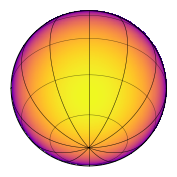

In [44]:
u1 = 0.246
u2 = 0.252

inc = 180-50
omega_s = 0.2/(np.sin(np.radians(inc))) #should create a function converting vsini to omega*sini
map33 = starry.Map(ydeg=4,udeg=2) #ydeg = 2*order_approx

arr = []

for i in ycoeffs:
    arr.append(float(i.evalf(subs={G:1, M:1.500, omega:omega_s, beta:0.22}))) #use G=1, M=1, omegaa = 0.60
arr = np.array(arr)
map33[1:,:] = ardr[1:]/(arr[0])

map33.rotate(axis=[1,0,0],theta=90)
map33[1] = u1
map33[2] = u2
star = starry.Primary(map33, m=1.59, r=1.561,prot=100000)

star.map.inc=inc
star.map.show()

Now, let's create a planet (also modeled on WASP-33b)

In [45]:
planet = starry.kepler.Secondary(map=starry.Map(lmax=2),
    m=0,  # mass in solar masses
    r=0.10714*star.r,  # radius in solar radii
    porb=1.2198696,  # orbital period in days
    inc=88.53,
    Omega=92,  # longitude of ascending node in degrees
    ecc=0.0,  # eccentricity
    w=0,  # longitude of pericenter in degrees
    t0=0,  # time of transit in days
)

system = starry.System(star, planet)

### Creating lightcurves and comparing to real data!

In [46]:
system.flux(0.0); #hack to compile and create lightcurves faster

In [47]:
%%time
time = np.linspace(planet.porb-0.15, planet.porb+0.15, 10000)
flux_star, flux_planet = system.flux(time, total=False)

CPU times: user 64.4 ms, sys: 15.8 ms, total: 80.2 ms
Wall time: 47.4 ms


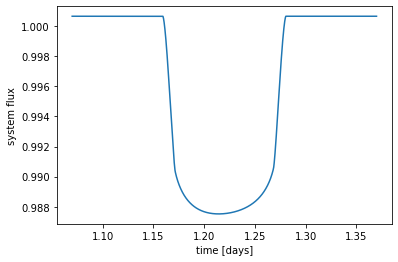

In [48]:
plt.plot(time, flux_star)
plt.xlabel("time [days]")
plt.ylabel("system flux");

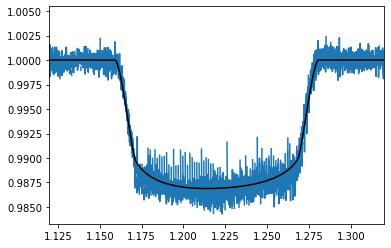

In [49]:
df = pd.read_csv("/Users/shashank/Documents/Python Files/wasp33TESS_clean.csv")
lc = lk.LightCurve(time=df.time,flux=df.flux)
wasp33_params = {'Epoch':2458792.63403-2457000, 'period':planet.porb,'tdur':0.1300}

fold = lc.fold(wasp33_params['period'],wasp33_params['Epoch'])
plt.xlim(planet.porb-0.1,planet.porb+0.1)
plt.plot(fold.phase*wasp33_params['period']+wasp33_params['period'],fold.flux)
plt.plot(time, flux_star/flux_star[0],c='k')

In [50]:
system.show(t=np.linspace(0, planet.porb, 50), window_pad=4, figsize=(8, 8))

In [ ]:
#plot one spheroid with Teff variation across the surface
def flux_star(omega,n):

    
    def get_one_F(omega,theta):
        r,T,F=ps.solve_ELR(omega,theta)
        return F
    
    Re=1.0
    Rp=Rp_div_Re(omega)*Re
   
    # Set of all spherical angles:
    phi = np.linspace(-np.pi, np.pi, n)
    nu = np.linspace(-np.pi/2, np.pi/2, n)

    angles=np.outer(np.ones_like(phi),nu)
    F=np.outer(np.ones_like(phi),np.ones_like(nu))
    for j in range(n):
        theta=angles[0,j]
        F[:,j]=get_one_F(omega,theta)
        
    if(Rp==Re): #spherical
        a=Re
        x=a*np.outer(np.cos(phi),np.cos(nu))
        y=a*np.outer(np.sin(phi),np.cos(nu))
        z=a*np.outer(np.ones_like(phi), np.sin(nu))
        
        F=np.outer(np.ones_like(phi), np.ones_like(nu))
        
    else: #spheroidal
        mu=np.arctanh(Rp/Re)
        a=np.sqrt(Re*Re - Rp*Rp)

        # Cartesian coordinates that correspond to the spherical angles:
        # (this is the equation of an ellipsoid):
        x = a*np.cosh(mu) * np.outer(np.cos(phi), np.cos(nu))
        y = a*np.cosh(mu) * np.outer(np.sin(phi), np.cos(nu))
        z = a*np.sinh(mu) * np.outer(np.ones_like(phi), np.sin(nu))
        Fmin=F.min()
        Fmax=F.max()
        F=(F-Fmin)/(Fmax - Fmin)
        
        return x, y, z, F
def rotate_star(x, y, z, theta, u):
    
    R = np.array([[np.cos(theta) + u[0]**2 * (1-np.cos(theta)), 
             u[0] * u[1] * (1-np.cos(theta)) - u[2] * np.sin(theta), 
             u[0] * u[2] * (1 - np.cos(theta)) + u[1] * np.sin(theta)],
            [u[0] * u[1] * (1-np.cos(theta)) + u[2] * np.sin(theta),
             np.cos(theta) + u[1]**2 * (1-np.cos(theta)),
             u[1] * u[2] * (1 - np.cos(theta)) - u[0] * np.sin(theta)],
            [u[0] * u[2] * (1-np.cos(theta)) - u[1] * np.sin(theta),
             u[1] * u[2] * (1-np.cos(theta)) + u[0] * np.sin(theta),
             np.cos(theta) + u[2]**2 * (1-np.cos(theta))]])
    return 